# Python Group
## Lab Assignment Six: Convolutional Network Architectures
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## 1. Business Understanding

Our dataset is composed of MRI images of brains with labels indicating whether the brain has a cancerous tumor or is normal. All images are black and white, but are composed of different image types, formats, and resolutions. Each image is labeled as cancerous or normal. The MRI scan may be top down or from a side profile perspective. The purpose of this dataset is to help automate the identification of cancerous tumors from a vast quantity of data generated by the MRI machine which generates an image for each "slice" of the three dimensional object placed inside through use of magnetic resonance. This data is important as the process of identifying a cancerous tumor is a vast quantity of MRI data can be tedious and error prone. Automating the discovery of a tumor can help a doctor zero in on specific portions of the data for review, may detect tumors a doctor may have missed, and generally assist with the procedure of analyzing MRI data. Since medical data will be reviewed by a doctor regardless of the outcome of the classifier, less than perfect results may still be helpful in diagnosis.

### Citation & Acknowledgement
The Brain Tumor Data Set dataset is licensed under the [GNU General Public License, version 2](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html) and was provided by Preet Viradiya on [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

In [ ]:
# Handle all imports for notebook
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from copy import deepcopy
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
import pprint

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Input
from keras.models import Model
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Embedding
from keras.layers import concatenate
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


import matplotlib
from matplotlib import image
import random
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from numpy import ndarray

from sklearn.metrics import mean_squared_error

from skimage.metrics import structural_similarity as ssim
import random

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

In [3]:
df: DataFrame = pd.read_csv("metadata.csv")
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


Immediately we can see that we have an unnamed title with a set of IDs, which can be safely removed

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


#### Resolutions by Count
It looks like the images are not particularly uniform in composition. Let's investigate further.

Resolutions by count:
 (512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
(251, 201, 3)     80
(217, 232, 3)     53
(168, 300, 3)     52
(221, 228, 3)     51
(198, 150, 3)     45
(252, 200, 3)     44
(417, 428, 3)     43
(222, 227, 3)     40
(201, 173, 3)     38
(244, 206, 3)     38
(442, 442, 3)     34
(192, 192, 3)     32
(250, 201, 3)     31
(231, 218, 3)     31
(234, 215, 3)     28
Name: shape, dtype: int64


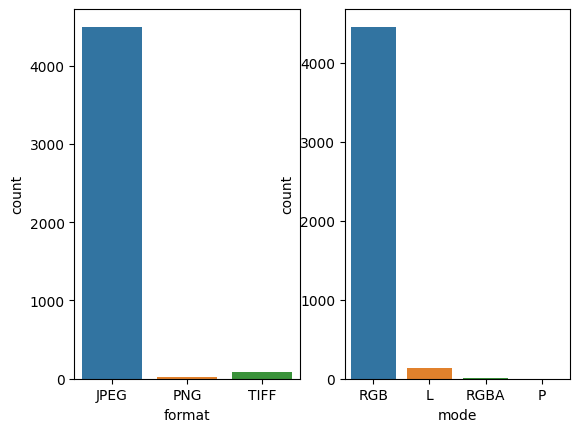

In [5]:
fig, ax = plt.subplots(1,2)
sns.countplot(x="format", data=df, ax=ax[0])
sns.countplot(x="mode", data=df, ax=ax[1])
print("Resolutions by count:\n", df["shape"].value_counts()[0:20])
# Way too many resolutions to plot...
#sns.countplot(x="shape", data=df, ax=ax[2])
plt.show()

We can see that we have a few different images that are not in the JPEG format and/or are not using the RGB or L (grayscale) color mode, which are both the most common. Since conversions would be computationally expensive and lossy, and since the number of images that are in the wrong format is relatively few, they will be dropped.
Resolutions will also be restricted to the largest square images in the top 20 most frequent resolutions, with all images to be downscaled to the smallest image to avoid losing data in trying to upscale (shown to be worse than downscaling by [this article](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89).

In [6]:
# First we identify undesirable images
# TODO: convert RGBA to RGB?
bad_columns = df[(df["format"] != "JPEG") | (df["mode"] != "RGB" | df["mode"] != "L") |
                 ((df["shape"] != "(630, 630, 3)")
                  & (df["shape"] != "(512, 512, 3)")
                  & (df["shape"] != "(442, 442, 3)")
                  & (df["shape"] != "(256, 256, 3)")
                  & (df["shape"] != "(236, 236, 3)")
                  & (df["shape"] != "(225, 225, 3)")
                  & (df["shape"] != "(192, 192, 3)"))]
df.drop(bad_columns.index, inplace=True)
bad_columns = bad_columns["image"] # For later deletion

In [7]:
# Then we remove images we don't want to convert or otherwise process
# We could import the images first and then delete from the numpy arrays to preserve the github dataset, but that's a lot of wasted time & space.
files = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
bad_files = [file for file in files if file in bad_columns.tolist()]
for file in bad_files:
    if "Not" in file:
        os.remove(join("Brain Tumor Data Set/Healthy/", file))
    else:
        os.remove(join("Brain Tumor Data Set/Brain Tumor/", file))

In [8]:
# Confirm we still have more than 1000 images
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 4585
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1548 non-null   object
 1   class   1548 non-null   object
 2   format  1548 non-null   object
 3   mode    1548 non-null   object
 4   shape   1548 non-null   object
dtypes: object(5)
memory usage: 72.6+ KB


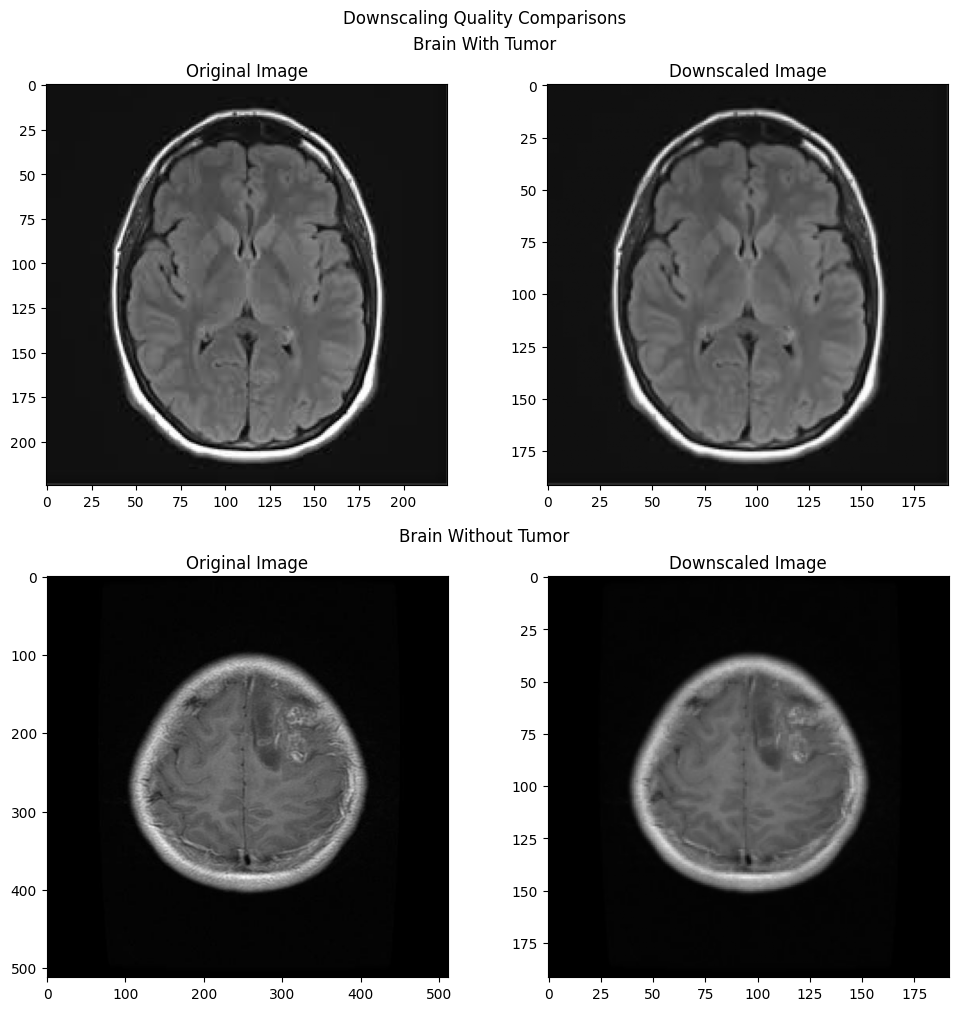

In [9]:
# Now import each image as a numpy array & do the final conversion of their resolutions
# Thoughts on what to do with resolutions? I say convert all to the smallest dimension (225x225)
cancer_images = []
healthy_images = []
original_images = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
for image in original_images:
    if "Not" in image:
        cancer_images.append(plt.imread(join("Brain Tumor Data Set/Healthy/", image)))
    else:
        healthy_images.append(plt.imread(join("Brain Tumor Data Set/Brain Tumor/", image)))

images = []
for image_set in (cancer_images, healthy_images): 
    for image in image_set:
        # Apply the resizing non-uniformly since evidently it affects images
        # even if they're the same size as the target resolution.
        # Difference with Linear PCA was:
        #   Applied to every image:
        #     233 components with λ > 1 for 92% explanation
        #   Applied to mis-sized images:
        #     256 components with λ > 1 for 99% explanation
        
        #images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        if len(image) != 192:
            resized = resize(image, (192, 192), anti_aliasing=True)
            #print(resized.shape)
            images.append(resized)
        else:
            #print(image.shape)
            images.append(image)
images = np.array(images)


fig = plt.figure(constrained_layout=True, figsize=(10,10))
fig.suptitle("Downscaling Quality Comparisons")
subfigs = fig.subfigures(2, 1)
ax_cancer = subfigs[0].subplots(1, 2)
subfigs[0].suptitle("Brain With Tumor")
ax_cancer[0].imshow(cancer_images[0], cmap='gray')
ax_cancer[0].set_title("Original Image")
ax_cancer[1].imshow(images[0].reshape(192, 192, 3), cmap='gray')
ax_cancer[1].set_title("Downscaled Image")
ax_healthy = subfigs[1].subplots(1, 2)
subfigs[1].suptitle("Brain Without Tumor")
ax_healthy[0].imshow(healthy_images[0], cmap='gray')
ax_healthy[0].set_title("Original Image")
ax_healthy[1].imshow(images[len(cancer_images)].reshape(192, 192, 3), cmap='gray')
ax_healthy[1].set_title("Downscaled Image")
plt.show()

## Preparation

#### Measurements Chosen

Ultimately, we chose the F1 score as our performance metric for the models. There are several factors we had to take to chose our performance metric for this particular task for the identification of Brain Tumors vs Healthy brains.

First, we had to consider the nature of the task at hand, which is classifying tumors in brains. Because this is a task with a high cost of misclassification, it is important for us to choose a performance metric which takes into account the trade-off between false positives and false negatives, and because the F1 score is the harmonic mean of precision and recall, it allows us to evaluate our model's ability to identify each class correctly and minimize both false positives and false negatives. This will ultimately help us choose the best model with the lowest false positive and false negative rates.

Secondly, initially we had many numerous image resolutions (see the Resolution by Count subsection above), each with varying degrees of frequency of images. Although we resolved this issue by dropping certain image resolutions until we only had 6 and also removed any images that were not JPEG or in RGB which made the data more uniform, there is still a high chance of an imbalanced class distribution. This is a problem because the model might perform well on the majority class but perform poorly on a minority class, but still achieve high accuracy. This is also another reason to use an additional metric such as the F1 score to give us further insight into model performance.

In addition to the F1-score, we will use a confusion matrix to visualize the performance of our model. This will provide insights into the specific misclassifications made by the model, helping us understand its strengths and weaknesses across different classes.

#### Dividing Data

We will use Stratified Shuffle Split so that we can preserve class distribution, meaning that we can preserve proportionality per class in our training and testing splits. It also allows us to introduce a degree of randomization in the data splitting process, reducing the probability of overfitting and helps our model generalize better. We can also specify the proportion we want to split by, so this gives us some additional flexibility and an additional parameter for us to experiment with finding the ideal test-train data proportional split. Given the additional randomization componenet of Stratified Shuffle Split, it mirrors the real world better because our model will encounter random

In [55]:
y_labels = df.loc[:,"class"]
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_labels)
y = le.transform(y_labels)

X = images


# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1238, 192, 192, 3)
(310, 192, 192, 3)
(1238,)
(310,)


## CNN

In [47]:
%%time

NUM_CLASSES = 2

# since this is not binary, we should go ahead and one-hot encode the inputs
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: total: 6h 12min 36s
Wall time: 11min 58s


In [61]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(192,192,3),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 192, 192, 16)      208       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 96, 16)       0         
 2D)                                                             
                                                                 
 activation_9 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 flatten_5 (Flatten)         (None, 147456)            0         
                                                                 
 dense_7 (Dense)             (None, 2)                 294914    
                                                                 
 activation_10 (Activation)  (None, 2)                 0         
                                                      

In [62]:
%%time 

print(X_train.shape)
# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(1238, 192, 192, 3)
CPU times: total: 12h 2min 17s
Wall time: 23min


In [63]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

10/10 [==============================] - 1s 47ms/step


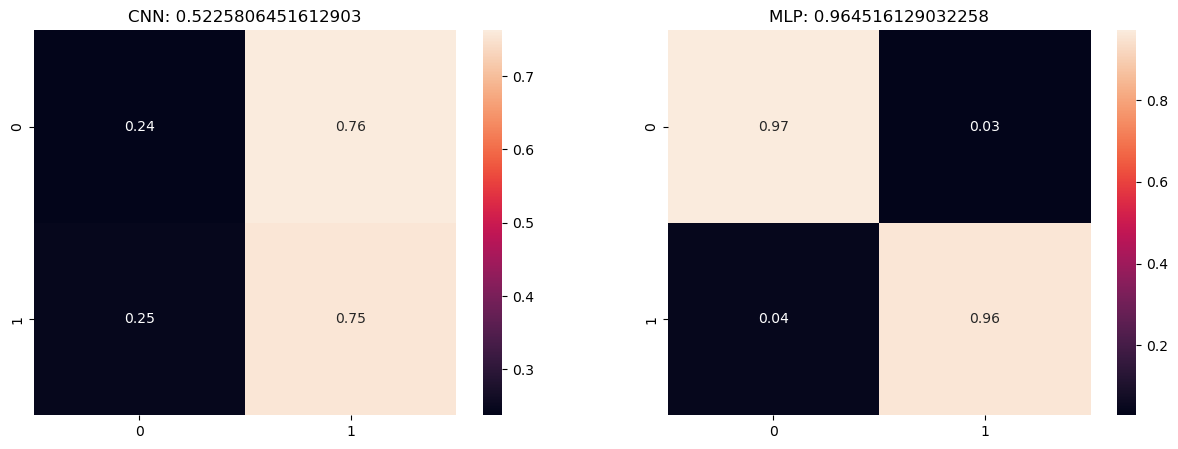

In [64]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

10/10 [==============================] - 1s 80ms/step
CPU times: total: 12h 34min 32s
Wall time: 24min 14s


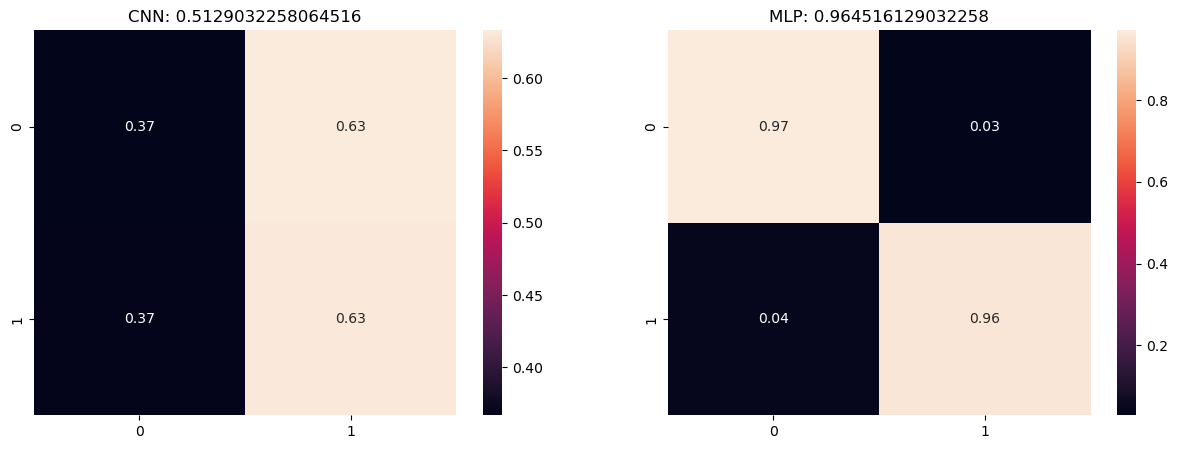

In [66]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), 
                padding='same', input_shape=(192,192,3),
                ) )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn2.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

10/10 [==============================] - 1s 68ms/step
CPU times: total: 1d 54min 49s
Wall time: 48min 58s


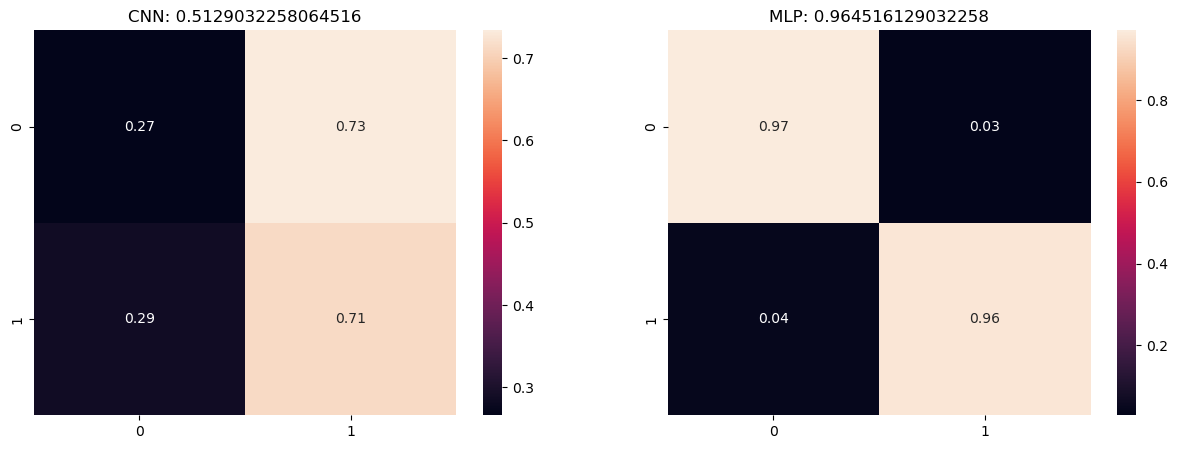

In [67]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn3.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

10/10 [==============================] - 1s 57ms/step
CPU times: total: 1d 7min 28s
Wall time: 47min 32s


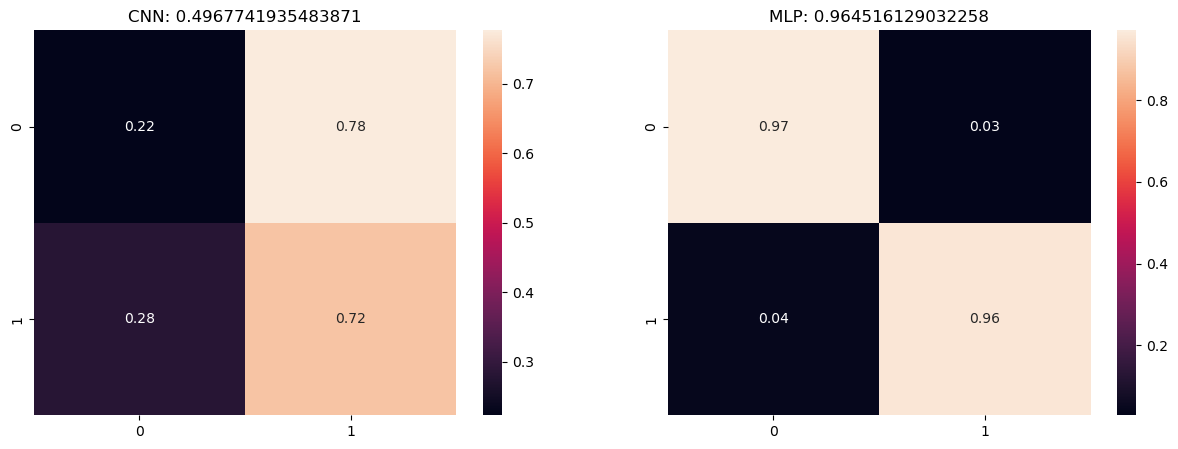

In [68]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()

num_filt_layers = [16, 32]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn4.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)